## IMPORTS

In [872]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("House_Rent_Dataset.csv")

In [873]:
data.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


### Exploratory Data Analysis

In [874]:
data['Tenant Preferred'].unique()

array(['Bachelors/Family', 'Bachelors', 'Family'], dtype=object)

In [875]:
data['Area Type'].unique()

array(['Super Area', 'Carpet Area', 'Built Area'], dtype=object)

<Axes: xlabel='BHK', ylabel='Rent'>

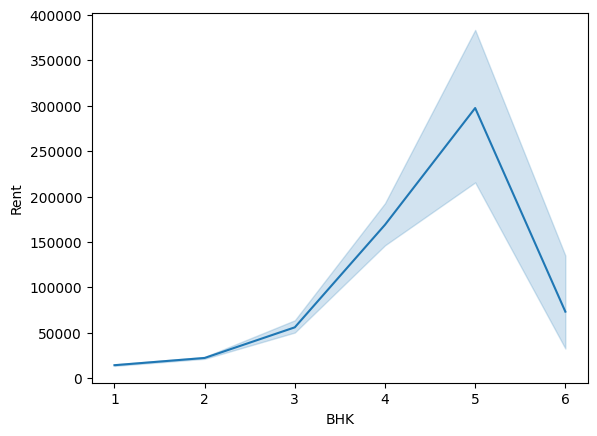

In [876]:
sns.lineplot(x='BHK', y='Rent', data=data)

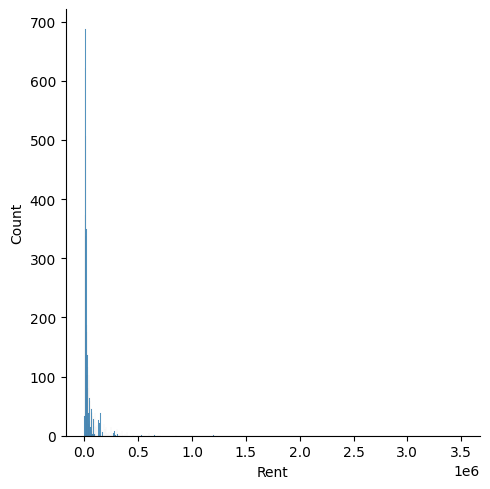

In [877]:
sns.displot(data['Rent'])

## Preprocessing

### Data Cleaning

In [878]:
data = data[['BHK',
             'Bathroom',
             'Furnishing Status',
             'Rent',
             'Size',
             #'Floor',
             'Area Type',
             'Tenant Preferred',
             'Point of Contact',
             #'Area Locality',
             'City'
             ]]

#### Removing Rent Outliers

In [879]:
Q1 = data['Rent'].quantile(0.25)
Q3 = data['Rent'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data = data[ (data['Rent'] >= lower_bound) & (data['Rent'] <= upper_bound)]

In [880]:
data.head()

,BHK,Bathroom,Furnishing Status,Rent,Size,Area Type,Tenant Preferred,Point of Contact,City
0,2,2,Unfurnished,10000,1100,Super Area,Bachelors/Family,Contact Owner,Kolkata
1,2,1,Semi-Furnished,20000,800,Super Area,Bachelors/Family,Contact Owner,Kolkata
2,2,1,Semi-Furnished,17000,1000,Super Area,Bachelors/Family,Contact Owner,Kolkata
3,2,1,Unfurnished,10000,800,Super Area,Bachelors/Family,Contact Owner,Kolkata
4,2,1,Unfurnished,7500,850,Carpet Area,Bachelors,Contact Owner,Kolkata


### Encoding

In [881]:
def one_hot_encode(data, column):
    encoded = pd.get_dummies(data[column], drop_first= True)
    data = data.drop(column, axis = 1)
    data = data.join(encoded)
    return data

data = one_hot_encode(data, 'Furnishing Status')
data = one_hot_encode(data, 'Tenant Preferred')
data = one_hot_encode(data, 'Point of Contact')
data = one_hot_encode(data, 'Area Type')
data = one_hot_encode(data, 'City')

In [882]:
data

,BHK,Bathroom,Rent,Size,Semi-Furnished,Unfurnished,Bachelors/Family,Family,Contact Builder,Contact Owner,Carpet Area,Super Area,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
0,2,2,10000,1100,False,True,True,False,False,True,False,True,False,False,False,True,False
1,2,1,20000,800,True,False,True,False,False,True,False,True,False,False,False,True,False
2,2,1,17000,1000,True,False,True,False,False,True,False,True,False,False,False,True,False
3,2,1,10000,800,False,True,True,False,False,True,False,True,False,False,False,True,False
4,2,1,7500,850,False,True,False,False,False,True,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2,2,15000,1000,True,False,True,False,False,True,True,False,False,False,True,False,False
4742,3,3,29000,2000,True,False,True,False,False,True,False,True,False,False,True,False,False
4743,3,3,35000,1750,True,False,True,False,False,False,True,False,False,False,True,False,False
4744,3,2,45000,1500,True,False,False,True,False,False,True,False,False,False,True,False,False


### Train/Test Splitting

In [883]:
X = data.drop('Rent', axis= 1)
y = data['Rent']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30, random_state = 42)

### Standardization

In [884]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [885]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)


## Modelling

In [886]:
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
model = linear_model.LinearRegression()
model = RidgeCV(alphas=[ 0.1, 1, 10])
model.fit(X_train, y_train)
model.coef_

array([ 0.00000000e+00,  1.90960359e+03,  1.54902226e+03,  5.45573758e+03,
       -5.65290345e+02, -8.29478334e+02, -1.88503788e+02, -5.45885225e+01,
       -8.42498666e-02, -1.35490933e+03,  2.06849235e+02, -2.04153322e+02,
       -1.45778638e+02,  5.96182830e+01, -2.13020703e+02, -1.45652486e+02,
        1.35046572e+03, -1.18642098e+02,  6.07343222e+02, -2.51824491e+02,
        8.73251089e+02,  9.64131686e+02, -4.63047955e+02, -1.99097706e+02,
       -3.50076974e+01, -2.65410685e+01, -4.81916642e+01,  4.60173684e+01,
        2.62549119e+02,  1.40689716e+02,  8.62834467e+01, -6.55298473e+01,
       -8.55509433e+01, -3.21053468e+02, -4.29237439e+01,  2.31081568e+02,
        2.26593058e+02,  1.51596002e+02, -2.15342950e+02, -2.83893169e+01,
       -6.66600460e+02,  2.26031652e+02, -2.28026191e+02,  7.52122656e+01,
        7.02289860e+02,  3.92562691e+02,  2.49401688e+02, -6.39524358e+02,
        2.60806381e+02, -1.27994220e+03, -1.57492514e+03,  1.78131818e+02,
        7.20075553e+02, -

In [887]:
# from sklearn.linear_model import RidgeCV

# model = RidgeCV()
# model.fit(X_train, y_train)


# Evaluation

In [888]:
y_preds = model.predict(X_test)

In [889]:
from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds))

Coefficients: 
 [ 0.00000000e+00  1.90960359e+03  1.54902226e+03  5.45573758e+03
 -5.65290345e+02 -8.29478334e+02 -1.88503788e+02 -5.45885225e+01
 -8.42498666e-02 -1.35490933e+03  2.06849235e+02 -2.04153322e+02
 -1.45778638e+02  5.96182830e+01 -2.13020703e+02 -1.45652486e+02
  1.35046572e+03 -1.18642098e+02  6.07343222e+02 -2.51824491e+02
  8.73251089e+02  9.64131686e+02 -4.63047955e+02 -1.99097706e+02
 -3.50076974e+01 -2.65410685e+01 -4.81916642e+01  4.60173684e+01
  2.62549119e+02  1.40689716e+02  8.62834467e+01 -6.55298473e+01
 -8.55509433e+01 -3.21053468e+02 -4.29237439e+01  2.31081568e+02
  2.26593058e+02  1.51596002e+02 -2.15342950e+02 -2.83893169e+01
 -6.66600460e+02  2.26031652e+02 -2.28026191e+02  7.52122656e+01
  7.02289860e+02  3.92562691e+02  2.49401688e+02 -6.39524358e+02
  2.60806381e+02 -1.27994220e+03 -1.57492514e+03  1.78131818e+02
  7.20075553e+02 -1.00246997e+02 -1.10498790e+03 -1.99663738e+02
  2.01309882e+02 -8.13373115e+02 -1.24292353e+03 -1.04140919e+03
 -7.03570

### Qualitative Evaluation

In [890]:
sample_data = X.iloc[0]
sample_data

BHK                     2
Bathroom                2
Size                 1100
Semi-Furnished      False
Unfurnished          True
Bachelors/Family     True
Family              False
Contact Builder     False
Contact Owner        True
Carpet Area         False
Super Area           True
Chennai             False
Delhi               False
Hyderabad           False
Kolkata              True
Mumbai              False
Name: 0, dtype: object

In [891]:
sample_data_standardized = poly.transform(X.iloc[0].values.reshape(1,-1))

In [892]:
model_rent_forecast = model.predict(sample_data_standardized)[0]
model_rent_forecast

318345178.5587974

In [893]:
y.iloc[0]

10000

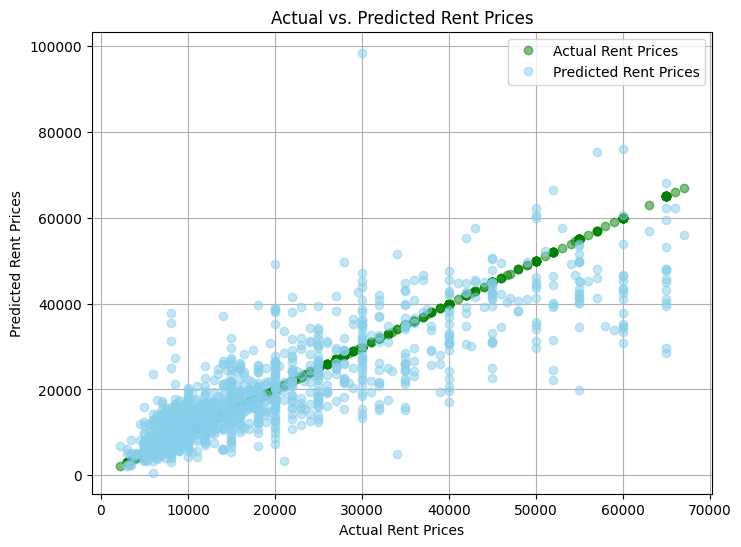

In [894]:
plt.figure(figsize=(8,6))
plt.plot(y_test, y_test, 'o', alpha=0.5, color='green', label='Actual Rent Prices')
plt.plot(y_test, y_preds, 'o', alpha=0.5, color='skyblue', label='Predicted Rent Prices')

plt.title("Actual vs. Predicted Rent Prices")
plt.xlabel("Actual Rent Prices")
plt.ylabel("Predicted Rent Prices")

plt.legend()
plt.grid(True)
plt.show()